In [1]:
from pathlib import Path
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

In [8]:
PATH_TO_DATA_DIR = Path(os.getcwd()).resolve().parent.parent / "Data"

PATH_TO_CLEANED_DICOM_DF = PATH_TO_DATA_DIR / "cleaned_dicom_df.feather"

PATH_TO_BINCOUNT_HU_DF = PATH_TO_DATA_DIR / "bincount_HU_df.feather"
PATH_TO_BINCOUNT_STEP_75_DF = PATH_TO_DATA_DIR / "bincount_STEP_75_df.feather"
PATH_TO_BINCOUNT_STEP_150_DF = PATH_TO_DATA_DIR / "bincount_STEP_150_df.feather"
PATH_TO_TRAIN_TEST_SPLIT = PATH_TO_DATA_DIR / "train_test_split.feather"

In [26]:
cleaned_dicom_df = pd.read_feather(PATH_TO_CLEANED_DICOM_DF)
train_test_split_df = pd.read_feather(PATH_TO_TRAIN_TEST_SPLIT)

train_test_split_df = train_test_split_df[train_test_split_df["set_type"] == "Train"]

cleaned_dicom_df = pd.merge(cleaned_dicom_df, train_test_split_df, on="SeriesInstanceUID")
cleaned_dicom_df

,PatientId,PatientAge,PatientSex,PatientWeight,PatientSize,BodyPart,Rows,Columns,SliceCount,PixelSpacing,SliceThickness,RescaleSlope,RescaleIntercept,SeriesInstanceUID,SliceDirectory,set_type
0,ANONYM-3X1ZSG_1,61,F,46.0,1.61,Stamm,512,512,263,0.976562,3.0,1.0,-1024.0,1.2.40.0.13.1.28611523484845610500759615941748...,/srv/GadM/Datasets/AIBA_CT_KG/2021-02/10046CC6...,Train
1,ANONYM-3X1ZSG_2,59,M,107.0,1.72,Stamm,512,512,293,0.976562,3.0,1.0,-1024.0,1.2.40.0.13.1.29372383852567236771106277061240...,/srv/GadM/Datasets/AIBA_CT_KG/2021-02/10046DD0...,Train
2,ANONYM-3X1ZSG_5,40,M,103.0,1.80,Stamm,512,512,625,1.171875,3.0,1.0,-1024.0,1.2.40.0.13.1.79959759832434680761991964822026...,/srv/GadM/Datasets/AIBA_CT_KG/2021-02/10047228...,Train
3,ANONYM-3X1ZSG_10,79,M,73.0,1.77,Stamm,512,512,567,1.171875,3.0,1.0,-1024.0,1.2.40.0.13.1.24209483531338511718074425173759...,/srv/GadM/Datasets/AIBA_CT_KG/2021-02/10047CFF...,Train
4,ANONYM-3X1ZSG_11,77,M,125.0,1.84,Stamm,512,512,623,1.171875,3.0,1.0,-1024.0,1.2.40.0.13.1.33709088158668319679757985067945...,/srv/GadM/Datasets/AIBA_CT_KG/2021-02/10047F39...,Train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2339,ANONYM-6LL37I_518,77,M,75.0,1.70,Stamm,512,512,567,1.171875,3.0,1.0,-1024.0,1.2.40.0.13.1.14447032145816928538722256306280...,/srv/GadM/Datasets/AIBA_CT_KG/2021-03/1006384E...,Train
2340,ANONYM-6LL37I_519,55,F,49.0,1.58,Stamm,512,512,567,1.171875,3.0,1.0,-1024.0,1.2.40.0.13.1.22055339428679588669178744381225...,/srv/GadM/Datasets/AIBA_CT_KG/2021-03/10063CCC...,Train
2341,ANONYM-6LL37I_520,51,F,63.0,1.74,Stamm,512,512,293,0.976562,3.0,1.0,-1024.0,1.2.40.0.13.1.15802889953337295246497758301352...,/srv/GadM/Datasets/AIBA_CT_KG/2021-03/10064142...,Train
2342,ANONYM-6LL37I_522,90,M,69.0,1.76,Stamm,512,512,567,1.171875,3.0,1.0,-1024.0,1.2.40.0.13.1.56298341537091980176000389528343...,/srv/GadM/Datasets/AIBA_CT_KG/2021-03/10064626...,Train


In [16]:
bincount_HU_df = pd.read_feather(PATH_TO_BINCOUNT_HU_DF)
bincount_STEP_75_df = pd.read_feather(PATH_TO_BINCOUNT_STEP_75_DF)
bincount_STEP_150_df = pd.read_feather(PATH_TO_BINCOUNT_STEP_150_DF)

In [17]:
merged_HU_df = pd.merge(cleaned_dicom_df, bincount_HU_df, on="SeriesInstanceUID", how="left")
merged_75_df = pd.merge(cleaned_dicom_df, bincount_STEP_75_df, on="SeriesInstanceUID", how="left")
merged_150_df = pd.merge(cleaned_dicom_df, bincount_STEP_150_df, on="SeriesInstanceUID", how="left")

In [18]:
merged_HU_df.head()

,PatientId,PatientAge,PatientSex,PatientWeight,PatientSize,BodyPart,Rows,Columns,SliceCount,PixelSpacing,...,Bone Cortical,Lung Parenchyma,Kidney,Liver,Lymph nodes,Muscle,Thymus (Children),Thymus (Adolescents),White matter,Grey matter
0,ANONYM-3X1ZSG_1,61,F,46.0,1.61,Stamm,512,512,263,0.976562,...,375405,278926,2173624,1326585,915460,2062969,1820525,4180326,1131634,1295282
1,ANONYM-3X1ZSG_2,59,M,107.0,1.72,Stamm,512,512,293,0.976562,...,537792,345860,3527092,1721158,2048264,2840256,3074768,6633570,2105339,1823933
2,ANONYM-3X1ZSG_5,40,M,103.0,1.80,Stamm,512,512,625,1.171875,...,556699,1541628,5474226,5961471,1592044,6978243,4175050,14773508,2204224,3842779
3,ANONYM-3X1ZSG_10,79,M,73.0,1.77,Stamm,512,512,567,1.171875,...,744304,1032802,4379945,2218171,2120429,3789554,3755211,7803960,2447463,2445554
4,ANONYM-3X1ZSG_11,77,M,125.0,1.84,Stamm,512,512,623,1.171875,...,512051,1969769,5841099,2340232,3437949,4463648,5138837,9541930,3555797,2962083


In [19]:
merged_75_df.head()

,PatientId,PatientAge,PatientSex,PatientWeight,PatientSize,BodyPart,Rows,Columns,SliceCount,PixelSpacing,...,750,825,900,975,1050,1125,1200,1275,1350,1425
0,ANONYM-3X1ZSG_1,61,F,46.0,1.61,Stamm,512,512,263,0.976562,...,204623,2058540,3555502,4025868,3654841,514849,377789,387216,456157,373146
1,ANONYM-3X1ZSG_2,59,M,107.0,1.72,Stamm,512,512,293,0.976562,...,423926,7224892,11652907,8911013,5548562,988490,501668,382291,342227,221254
2,ANONYM-3X1ZSG_5,40,M,103.0,1.80,Stamm,512,512,625,1.171875,...,565783,7793668,14322996,9169355,13861626,2095370,777588,608628,410042,255482
3,ANONYM-3X1ZSG_10,79,M,73.0,1.77,Stamm,512,512,567,1.171875,...,639829,6460314,10781662,9037279,6616514,1049959,630514,447763,355870,247149
4,ANONYM-3X1ZSG_11,77,M,125.0,1.84,Stamm,512,512,623,1.171875,...,1457807,12857045,24653912,14749968,7703638,1301165,767511,551674,358191,217579


In [20]:
merged_150_df.head()

,PatientId,PatientAge,PatientSex,PatientWeight,PatientSize,BodyPart,Rows,Columns,SliceCount,PixelSpacing,...,0,150,300,450,600,750,900,1050,1200,1350
0,ANONYM-3X1ZSG_1,61,F,46.0,1.61,Stamm,512,512,263,0.976562,...,52469016,839092,284233,182347,167027,204623,3555502,3654841,377789,456157
1,ANONYM-3X1ZSG_2,59,M,107.0,1.72,Stamm,512,512,293,0.976562,...,45197709,1115406,363675,192230,161841,423926,11652907,5548562,501668,342227
2,ANONYM-3X1ZSG_5,40,M,103.0,1.80,Stamm,512,512,625,1.171875,...,99062094,10483093,1782300,576921,524370,565783,14322996,13861626,777588,410042
3,ANONYM-3X1ZSG_10,79,M,73.0,1.77,Stamm,512,512,567,1.171875,...,95801339,8410955,1089065,590328,530883,639829,10781662,6616514,630514,355870
4,ANONYM-3X1ZSG_11,77,M,125.0,1.84,Stamm,512,512,623,1.171875,...,78937828,16443586,2384668,882332,1078506,1457807,24653912,7703638,767511,358191


In [21]:
target = merged_HU_df['PatientWeight']

In [22]:
merged_HU_df.loc[:, 'VoxelVolume'] = (merged_HU_df['PixelSpacing'] ** 2) * merged_HU_df['SliceThickness']
merged_75_df.loc[:, 'VoxelVolume'] = (merged_75_df['PixelSpacing'] ** 2) * merged_75_df['SliceThickness']
merged_150_df.loc[:, 'VoxelVolume'] = (merged_150_df['PixelSpacing'] ** 2) * merged_150_df['SliceThickness']

voxel_columns_HU = ["Air", "Fat", "Soft tissue on contrast CT", "Bone Cancellous", "Bone Cortical", "Lung Parenchyma", "Kidney", "Liver", "Lymph nodes", "Muscle", "Thymus (Children)", "Thymus (Adolescents)", "White matter", "Grey matter",]
voxel_columns_75 = [str(i) for i in range(0, 1500, 75)]
voxel_columns_150 = [str(i) for i in range(0, 1500, 150)]

def apply_voxel_volume(row, voxel_columns):
    return row[voxel_columns] * row['VoxelVolume']

transformed_HU_df = merged_HU_df.copy()
transformed_75_df = merged_75_df.copy()
transformed_150_df = merged_150_df.copy()

transformed_HU_df[voxel_columns_HU] = merged_HU_df.apply(lambda row: apply_voxel_volume(row, voxel_columns_HU), axis=1)
transformed_75_df[voxel_columns_75] = merged_75_df.apply(lambda row: apply_voxel_volume(row, voxel_columns_75), axis=1)
transformed_150_df[voxel_columns_150] = merged_150_df.apply(lambda row: apply_voxel_volume(row, voxel_columns_150), axis=1)

In [23]:
transformed_HU_df['PatientSex_encoded'] = transformed_HU_df['PatientSex'].map({'F': 0, 'M': 1})
transformed_75_df['PatientSex_encoded'] = transformed_75_df['PatientSex'].map({'F': 0, 'M': 1})
transformed_150_df['PatientSex_encoded'] = transformed_150_df['PatientSex'].map({'F': 0, 'M': 1})

In [25]:
base_columns_to_drop = ['PatientWeight', 'PatientId','Rows', 'Columns', 'RescaleSlope', 'RescaleIntercept', 'SeriesInstanceUID', 'SliceDirectory', 'BodyPart', 'PixelSpacing', 'SliceThickness', 'PatientSex', 'set_type'] # These columns wont be used in training

cleaned_HU_df = transformed_HU_df.drop(columns=base_columns_to_drop)
cleaned_75_df = transformed_75_df.drop(columns=base_columns_to_drop)
cleaned_150_df = transformed_150_df.drop(columns=base_columns_to_drop)

cleaned_HU_df

# remove_columns = ['PatientAge', 'PatientSex', 'PatientSize', 'BodyPart', 'SliceCount', 'PixelSpacing', 'SliceThickness']

,PatientAge,PatientSize,SliceCount,Air,Fat,Soft tissue on contrast CT,Bone Cancellous,Bone Cortical,Lung Parenchyma,Kidney,Liver,Lymph nodes,Muscle,Thymus (Children),Thymus (Adolescents),White matter,Grey matter,VoxelVolume,PatientSex_encoded
0,61,1.61,263,1.331415e+08,5.708968e+06,2.773973e+06,1.475987e+06,1.074042e+06,7.980137e+05,6.218788e+06,3.795390e+06,2.619152e+06,5.902202e+06,5.208564e+06,1.196001e+07,3.237631e+06,3.705832e+06,2.861023,0
1,59,1.72,293,1.109339e+08,1.775373e+07,4.600047e+06,1.222398e+06,1.538635e+06,9.895134e+05,1.009109e+07,4.924273e+06,5.860130e+06,8.126038e+06,8.796982e+06,1.897880e+07,6.023423e+06,5.218314e+06,2.861023,1
2,40,1.80,625,3.213630e+08,4.178550e+07,1.327723e+07,2.368667e+06,2.293529e+06,6.351312e+06,2.255312e+07,2.456050e+07,6.559019e+06,2.874948e+07,1.720068e+07,6.086498e+07,9.081123e+06,1.583176e+07,4.119873,1
3,79,1.77,567,2.954242e+08,2.580361e+07,7.222591e+06,1.908457e+06,3.066438e+06,4.255013e+06,1.804482e+07,9.138583e+06,8.735898e+06,1.561248e+07,1.547099e+07,3.215132e+07,1.008324e+07,1.007537e+07,4.119873,1
4,77,1.84,623,2.501823e+08,5.683215e+07,8.864653e+06,2.099170e+06,2.109585e+06,8.115198e+06,2.406459e+07,9.641459e+06,1.416391e+07,1.838966e+07,2.117136e+07,3.931154e+07,1.464943e+07,1.220341e+07,4.119873,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2339,77,1.70,567,2.680978e+08,1.576125e+07,7.706544e+06,1.918711e+06,2.791198e+06,5.949896e+06,2.470258e+07,1.352078e+07,1.077536e+07,2.252092e+07,2.090521e+07,4.393012e+07,1.322283e+07,1.439278e+07,4.119873,1
2340,55,1.58,567,3.444623e+08,8.955216e+06,4.076516e+06,9.103313e+05,1.515059e+06,4.694237e+06,1.725496e+07,1.214961e+07,6.064568e+06,1.814101e+07,1.400105e+07,3.275185e+07,8.120191e+06,1.111412e+07,4.119873,0
2341,51,1.74,293,1.429372e+08,7.711541e+06,3.669997e+06,1.656638e+06,1.362997e+06,9.017258e+05,8.539721e+06,5.719840e+06,3.390361e+06,8.420171e+06,7.086940e+06,1.737182e+07,4.328284e+06,5.206967e+06,2.861023,0
2342,90,1.76,567,2.816512e+08,2.409683e+07,6.953884e+06,1.708075e+06,1.831131e+06,5.685812e+06,1.887968e+07,9.703805e+06,8.093977e+06,1.717050e+07,1.595475e+07,3.248702e+07,9.993312e+06,1.111480e+07,4.119873,1


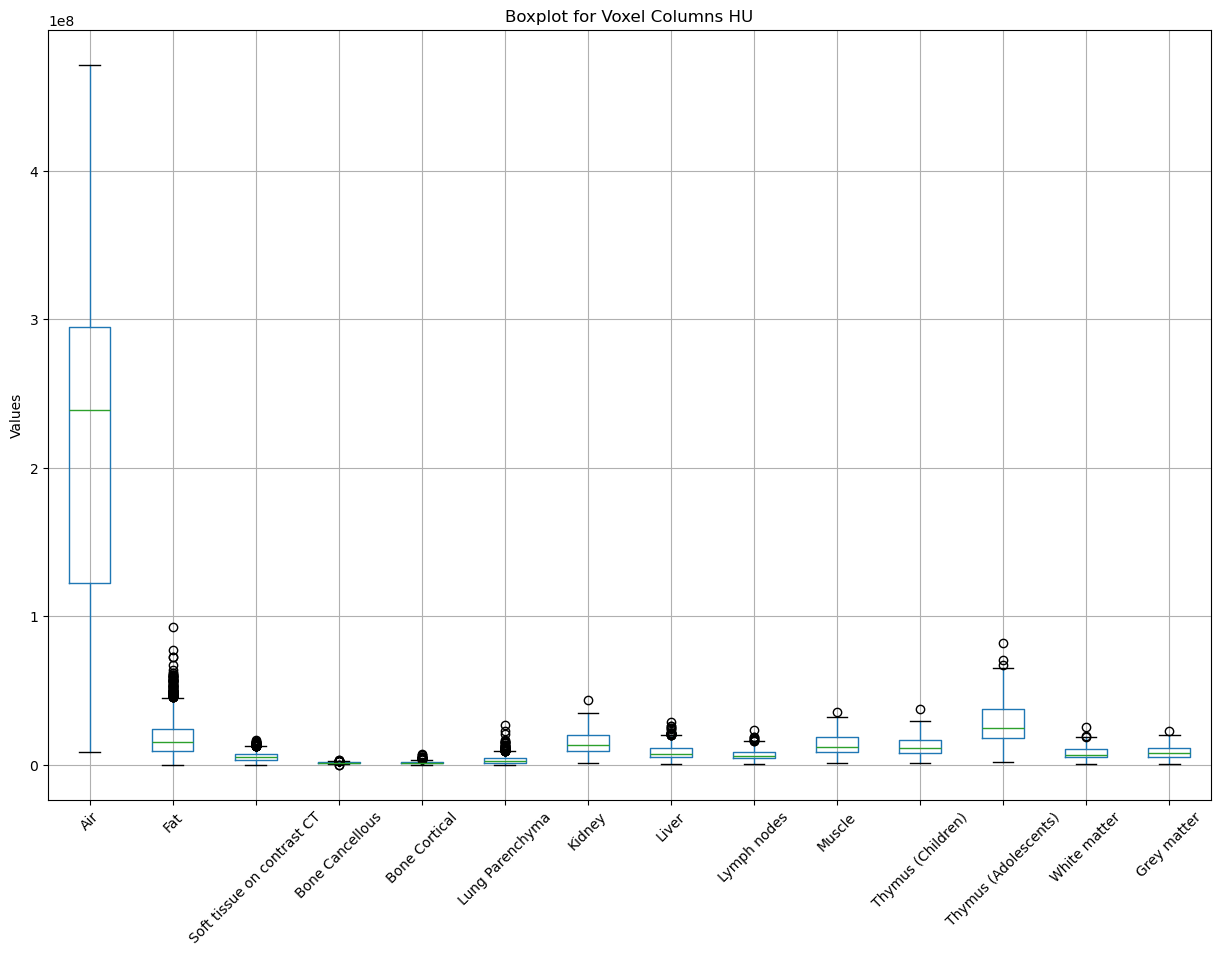

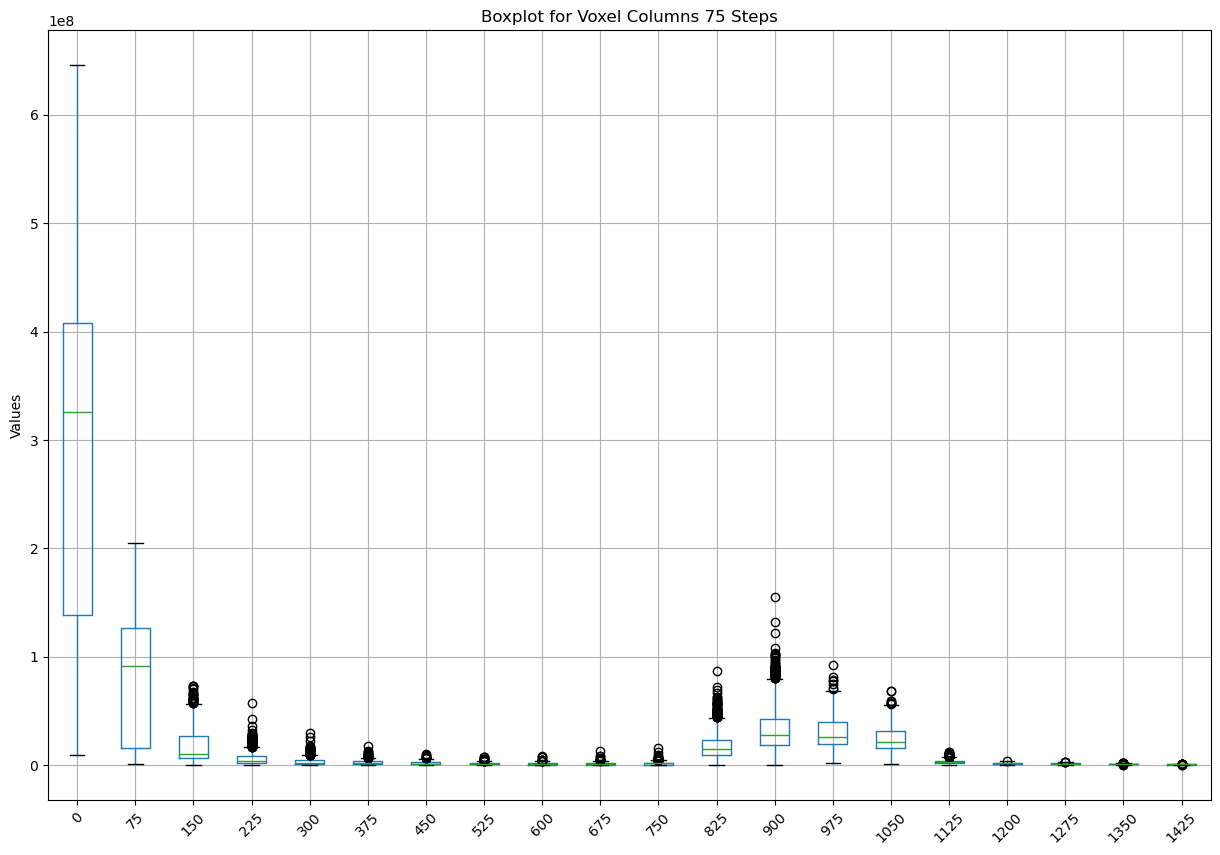

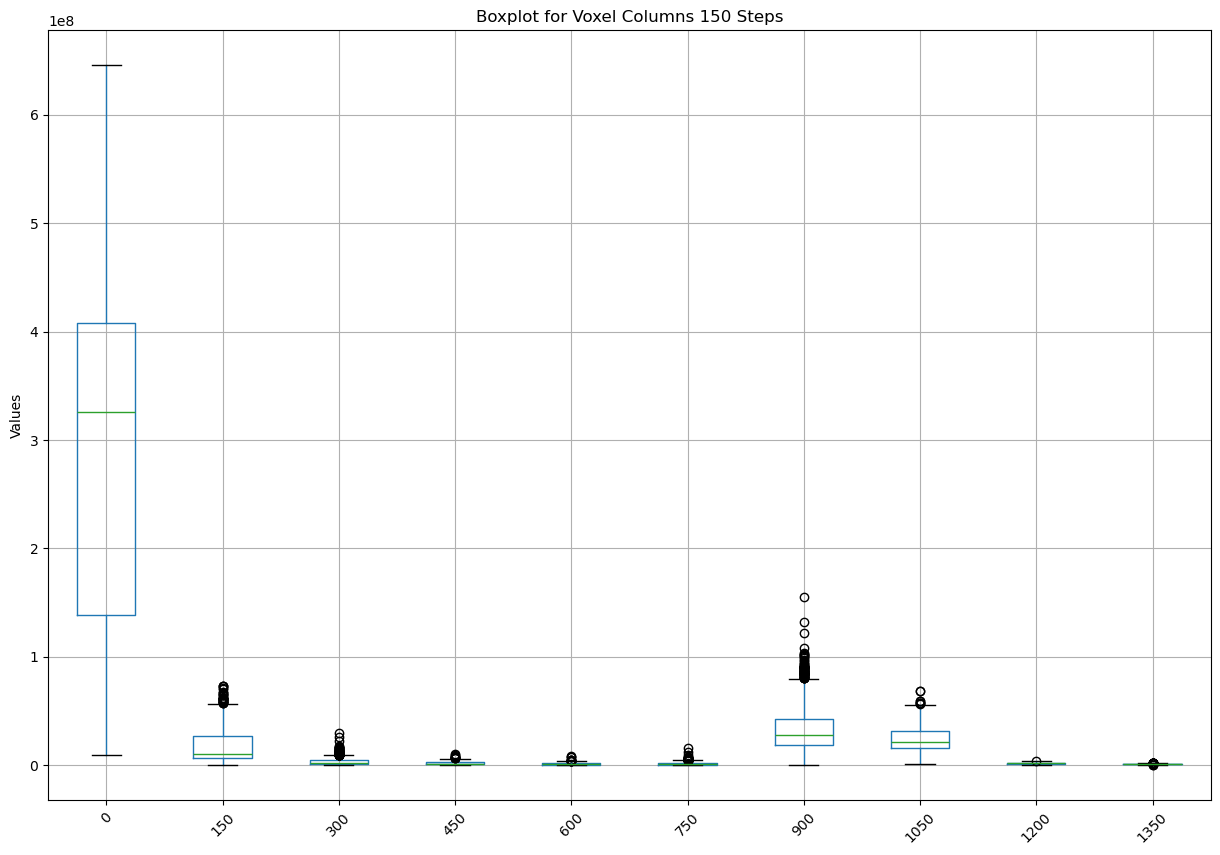

In [14]:
# Create a boxplot for the columns in voxel_columns_HU
cleaned_HU_df[voxel_columns_HU].boxplot(figsize=(15, 10))
plt.xticks(rotation=45)
plt.title('Boxplot for Voxel Columns HU')
plt.ylabel('Values')
plt.show()

# Create a boxplot for the columns in voxel_columns_HU
cleaned_75_df[voxel_columns_75].boxplot(figsize=(15, 10))
plt.xticks(rotation=45)
plt.title('Boxplot for Voxel Columns 75 Steps')
plt.ylabel('Values')
plt.show()

# Create a boxplot for the columns in voxel_columns_HU
cleaned_150_df[voxel_columns_150].boxplot(figsize=(15, 10))
plt.xticks(rotation=45)
plt.title('Boxplot for Voxel Columns 150 Steps')
plt.ylabel('Values')
plt.show()

In [95]:
cleaned_HU_df

,PatientAge,PatientSize,SliceCount,Air,Fat,Soft tissue on contrast CT,Bone Cancellous,Bone Cortical,Lung Parenchyma,Kidney,Liver,Lymph nodes,Muscle,Thymus (Children),Thymus (Adolescents),White matter,Grey matter,VoxelVolume,PatientSex_encoded
1,61,1.61,263,1.331415e+08,5.708968e+06,2.773973e+06,1.475987e+06,1.074042e+06,7.980137e+05,6.218788e+06,3.795390e+06,2.619152e+06,5.902202e+06,5.208564e+06,1.196001e+07,3.237631e+06,3.705832e+06,2.861023,0
2,59,1.72,293,1.109339e+08,1.775373e+07,4.600047e+06,1.222398e+06,1.538635e+06,9.895134e+05,1.009109e+07,4.924273e+06,5.860130e+06,8.126038e+06,8.796982e+06,1.897880e+07,6.023423e+06,5.218314e+06,2.861023,1
5,40,1.80,625,3.213630e+08,4.178550e+07,1.327723e+07,2.368667e+06,2.293529e+06,6.351312e+06,2.255312e+07,2.456050e+07,6.559019e+06,2.874948e+07,1.720068e+07,6.086498e+07,9.081123e+06,1.583176e+07,4.119873,1
10,79,1.77,567,2.954242e+08,2.580361e+07,7.222591e+06,1.908457e+06,3.066438e+06,4.255013e+06,1.804482e+07,9.138583e+06,8.735898e+06,1.561248e+07,1.547099e+07,3.215132e+07,1.008324e+07,1.007537e+07,4.119873,1
11,77,1.84,623,2.501823e+08,5.683215e+07,8.864653e+06,2.099170e+06,2.109585e+06,8.115198e+06,2.406459e+07,9.641459e+06,1.416391e+07,1.838966e+07,2.117136e+07,3.931154e+07,1.464943e+07,1.220341e+07,4.119873,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5035,77,1.70,567,2.680978e+08,1.576125e+07,7.706544e+06,1.918711e+06,2.791198e+06,5.949896e+06,2.470258e+07,1.352078e+07,1.077536e+07,2.252092e+07,2.090521e+07,4.393012e+07,1.322283e+07,1.439278e+07,4.119873,1
5036,55,1.58,567,3.444623e+08,8.955216e+06,4.076516e+06,9.103313e+05,1.515059e+06,4.694237e+06,1.725496e+07,1.214961e+07,6.064568e+06,1.814101e+07,1.400105e+07,3.275185e+07,8.120191e+06,1.111412e+07,4.119873,0
5037,51,1.74,293,1.429372e+08,7.711541e+06,3.669997e+06,1.656638e+06,1.362997e+06,9.017258e+05,8.539721e+06,5.719840e+06,3.390361e+06,8.420171e+06,7.086940e+06,1.737182e+07,4.328284e+06,5.206967e+06,2.861023,0
5039,90,1.76,567,2.816512e+08,2.409683e+07,6.953884e+06,1.708075e+06,1.831131e+06,5.685812e+06,1.887968e+07,9.703805e+06,8.093977e+06,1.717050e+07,1.595475e+07,3.248702e+07,9.993312e+06,1.111480e+07,4.119873,1


In [ ]:
def find_best_model(X, y):
    param_grid = {
        'n_estimators': [50, 100, 150, 200],
        'max_depth': [3, 5, 7, 9],
        'min_samples_split': [2, 4, 6, 8],
        'min_samples_leaf': [1, 2, 3, 4]
    }

    gb = GradientBoostingRegressor()
    grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
    grid_search.fit(X, y)
    
    print(grid_search.best_params_)
    return grid_search.best_estimator_

In [104]:
print('Finding best model for HU')
best_model_HU = find_best_model(cleaned_HU_df, target)
print('Finding best model for 75')
best_model_75 = find_best_model(cleaned_75_df, target)
print('Finding best model for 150')
best_model_150 = find_best_model(cleaned_150_df, target)

Finding best model for HU
Fitting 5 folds for each of 256 candidates, totalling 1280 fits
{'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Finding best model for 75
Fitting 5 folds for each of 256 candidates, totalling 1280 fits
{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 200}
Finding best model for 150
Fitting 5 folds for each of 256 candidates, totalling 1280 fits
{'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 200}


Best parameters HU:
``` python
{'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
```
Best parameters 75:
``` python
{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 200}
```
Best parameters 150:
``` python
{'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 200}
```

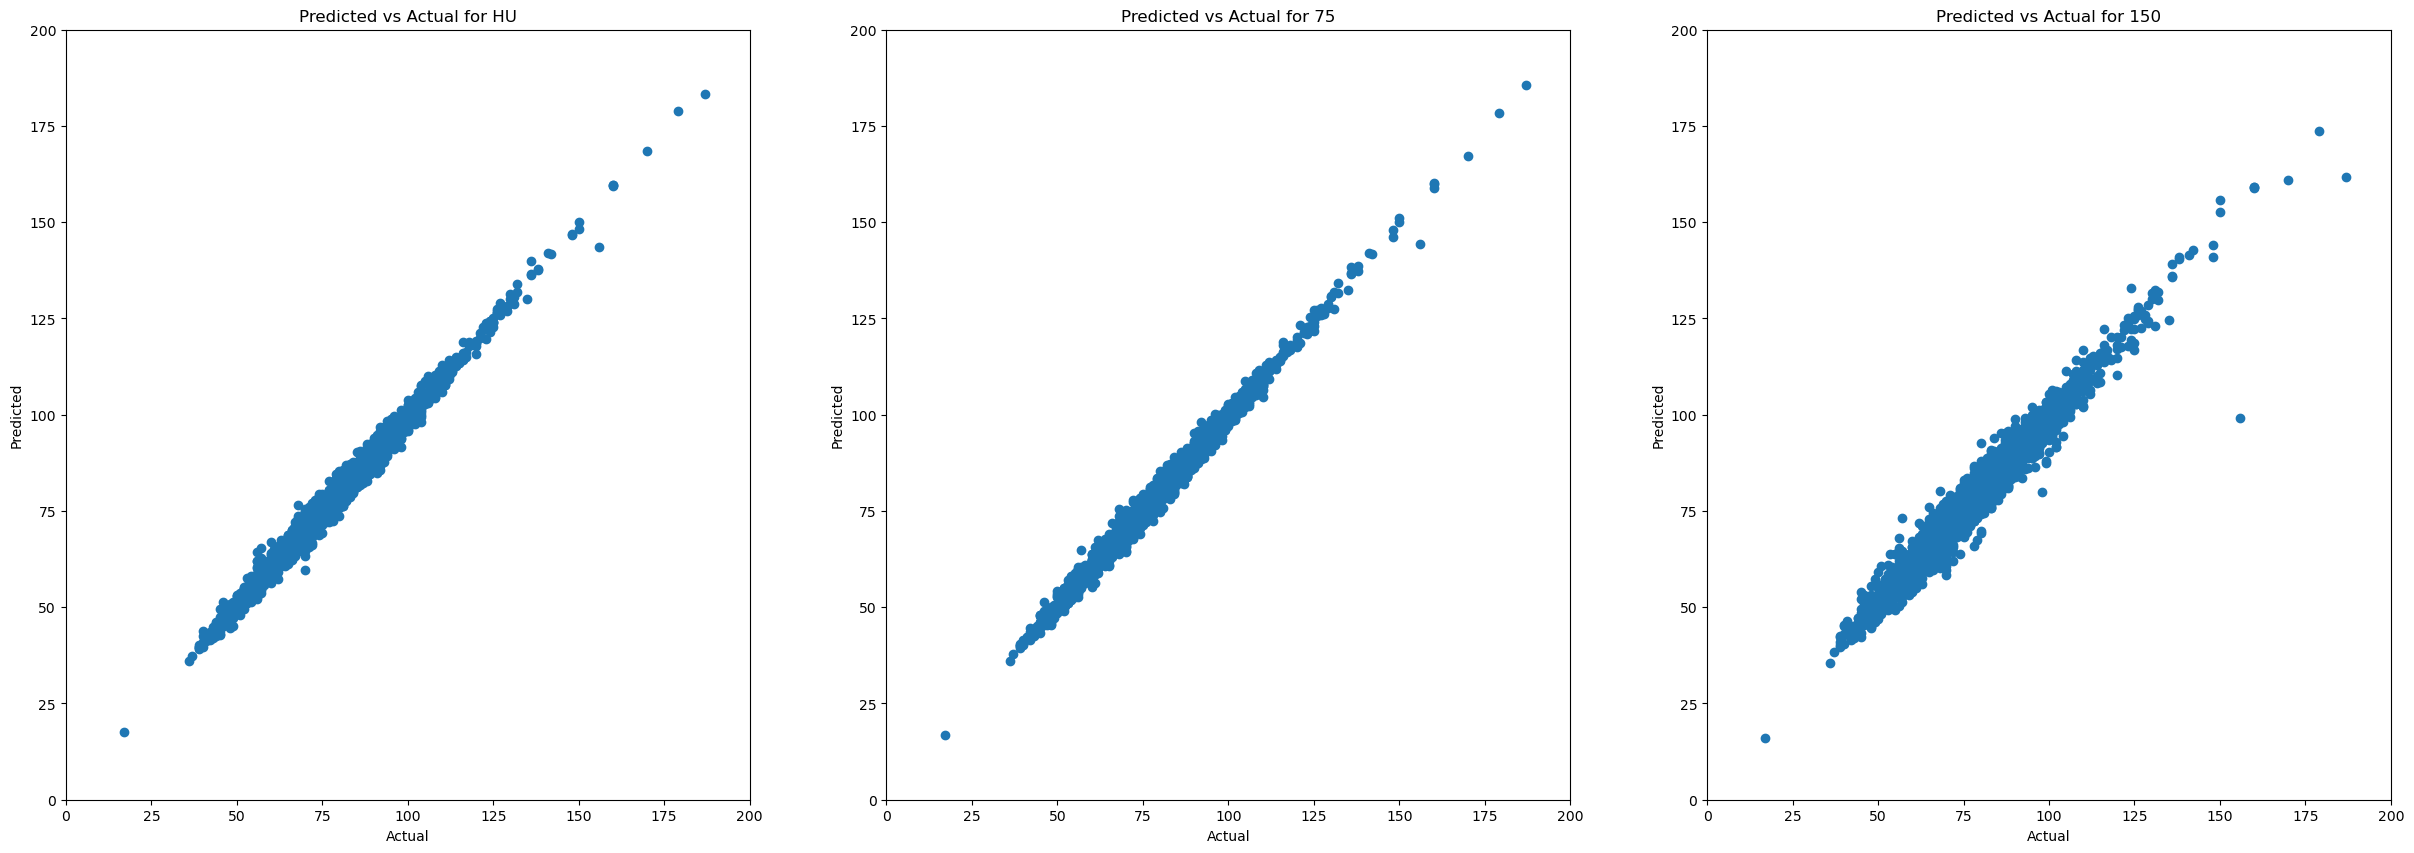

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(30, 10))

axs[0].set_ylim([0, 200])
axs[1].set_ylim([0, 200])
axs[2].set_ylim([0, 200])

axs[0].set_xlim([0, 200])
axs[1].set_xlim([0, 200])
axs[2].set_xlim([0, 200])

axs[0].scatter(target, best_model_HU.predict(cleaned_HU_df))
axs[0].set_title('Predicted vs Actual for HU')
axs[0].set_xlabel('Actual')
axs[0].set_ylabel('Predicted')

axs[1].scatter(target, best_model_75.predict(cleaned_75_df))
axs[1].set_title('Predicted vs Actual for 75')
axs[1].set_xlabel('Actual')
axs[1].set_ylabel('Predicted')

axs[2].scatter(target, best_model_150.predict(cleaned_150_df))
axs[2].set_title('Predicted vs Actual for 150')
axs[2].set_xlabel('Actual')
axs[2].set_ylabel('Predicted')

plt.show()

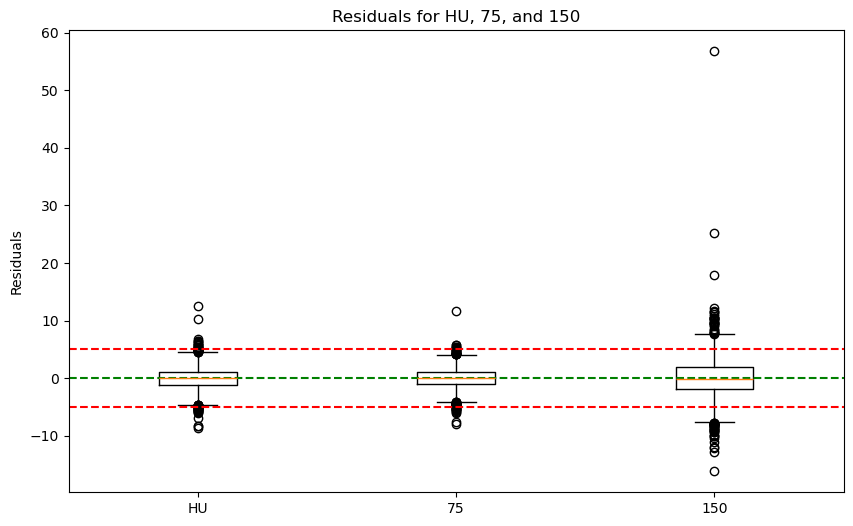

In [121]:
residuals_HU = target - best_model_HU.predict(cleaned_HU_df)
residuals_75 = target - best_model_75.predict(cleaned_75_df)
residuals_150 = target - best_model_150.predict(cleaned_150_df)

plt.figure(figsize=(10, 6))
plt.boxplot([residuals_HU, residuals_75, residuals_150], tick_labels=['HU', '75', '150'])

plt.ylabel('Residuals')
plt.title('Residuals for HU, 75, and 150')

# Draw a horizontal line at 0 and 5
plt.axhline(y=0, color='g', linestyle='--')
plt.axhline(y=5, color='r', linestyle='--')
plt.axhline(y=-5, color='r', linestyle='--')

plt.show()

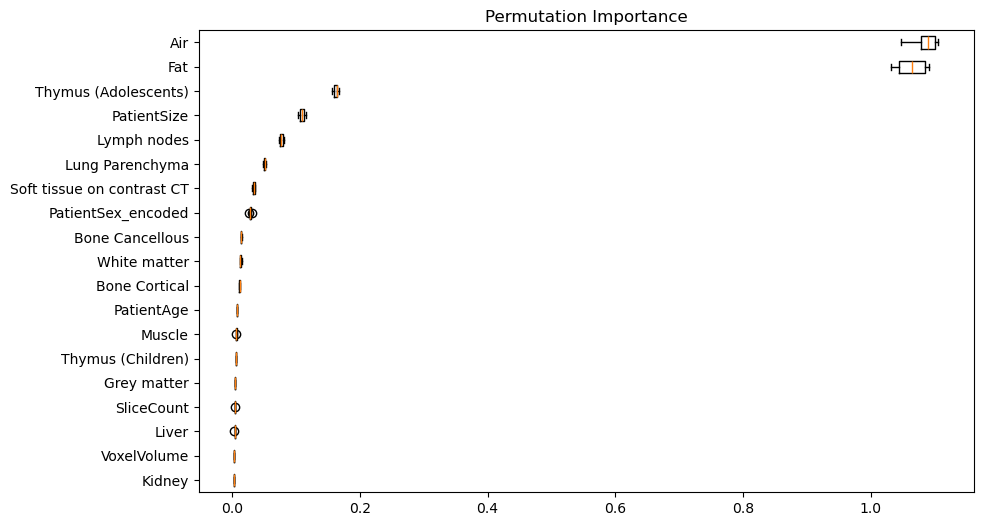

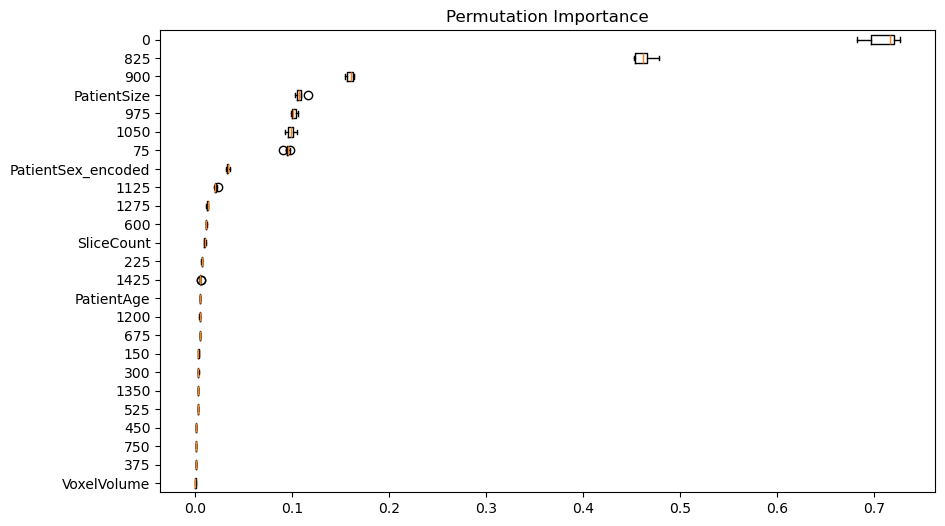

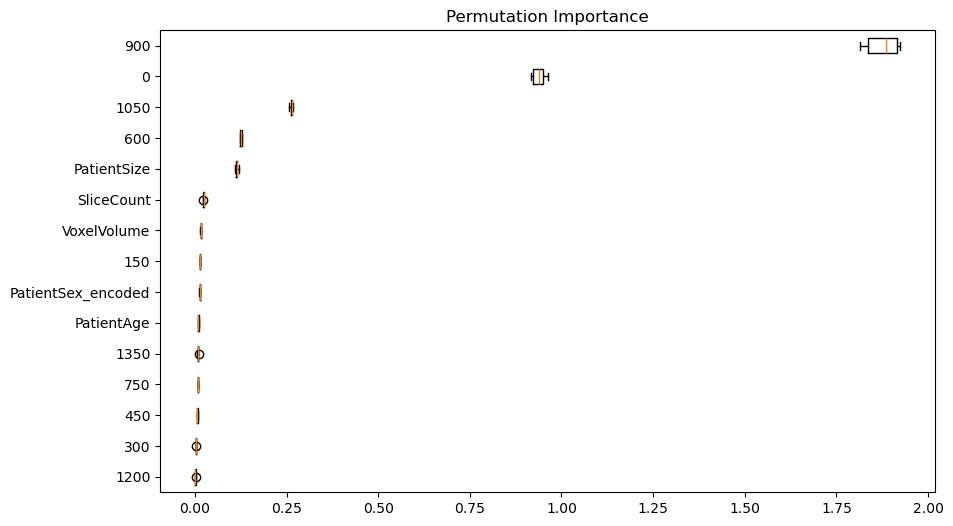

In [ ]:
# Calculate the permutation importance for the models
def calculate_permutation_importance(model, X, y):
    result = permutation_importance(model, X, y, n_repeats=10, random_state=42, n_jobs=-1)
    return result

perm_importance_HU = calculate_permutation_importance(best_model_HU, cleaned_HU_df, target)
perm_importance_75 = calculate_permutation_importance(best_model_75, cleaned_75_df, target)
perm_importance_150 = calculate_permutation_importance(best_model_150, cleaned_150_df, target)

def plot_permutation_importance(perm_importance, X):
    sorted_idx = perm_importance.importances_mean.argsort()
    plt.figure(figsize=(10, 6))
    plt.boxplot(perm_importance.importances[sorted_idx].T, vert=False, tick_labels=X.columns[sorted_idx])
    plt.title('Permutation Importance')
    plt.show()

plot_permutation_importance(perm_importance_HU, cleaned_HU_df)
plot_permutation_importance(perm_importance_75, cleaned_75_df)
plot_permutation_importance(perm_importance_150, cleaned_150_df)

# Calculate the SHAP values for the models

In [19]:
def calculate_metrics(model, X, y):
    y_pred = model.predict(X)
    mae = mean_absolute_error(y, y_pred)
    rmse = root_mean_squared_error(y, y_pred)
    return mae, rmse

In [ ]:
mae_HU, rmse_HU = calculate_metrics(best_model_HU, cleaned_HU_df, target)
mae_75, rmse_75 = calculate_metrics(best_model_75, cleaned_75_df, target)
mae_150, rmse_150 = calculate_metrics(best_model_150, cleaned_150_df, target)

print(f'MAE for HU: {mae_HU}, RMSE for HU: {rmse_HU}')
print(f'MAE for 75: {mae_75}, RMSE for 75: {rmse_75}')
print(f'MAE for 150: {mae_150}, RMSE for 150: {rmse_150}')

NameError: name 'best_model_HU' is not defined

In [ ]:
# scikit-optimize
def find_best_model_bayes(X, y):
    param_space = {
        
        'loss': Categorical(['squared_error', 'absolute_error', 'huber', 'quantile']),
        'learning_rate': Real(0.01, 0.2, prior='log-uniform'),
        'n_estimators': Integer(50, 500),
        'subsample': Real(0.5, 1.0, prior='uniform'),
        'criterion': Categorical(['friedman_mse', 'squared_error']),
        'min_samples_split': Integer(2, 10),
        'min_samples_leaf': Integer(1, 4),
        'min_weight_fraction_leaf': Real(0.0, 0.5, prior='uniform'),
        'max_depth': Integer(1, 9),
        'max_leaf_nodes': Integer(2, 10),
    }

    gb = GradientBoostingRegressor()
    bayes_search = BayesSearchCV(estimator=gb, search_spaces=param_space, n_iter=256, cv=5, n_jobs=-1, verbose=2)
    bayes_search.fit(X, y)
    
    print(bayes_search.best_params_)
    return bayes_search.best_estimator_

print('Finding best model for HU')
best_model_HU_bayes = find_best_model_bayes(cleaned_HU_df, target)
print('Finding best model for 75')
best_model_75_bayes = find_best_model_bayes(cleaned_75_df, target)
print('Finding best model for 150')
best_model_150_bayes = find_best_model_bayes(cleaned_150_df, target)

Finding best model for HU
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 

Best parameters HU
```python
OrderedDict([('criterion', 'friedman_mse'), ('learning_rate', 0.13303724816777396), ('loss', 'huber'), ('max_depth', 9), ('max_leaf_nodes', 10), ('min_samples_leaf', 4), ('min_samples_split', 10), ('min_weight_fraction_leaf', 0.0), ('n_estimators', 235), ('subsample', 0.5)])
```
Best parameters 75
```python
OrderedDict([('criterion', 'friedman_mse'), ('learning_rate', 0.08650019912913393), ('loss', 'huber'), ('max_depth', 4), ('max_leaf_nodes', 10), ('min_samples_leaf', 4), ('min_samples_split', 4), ('min_weight_fraction_leaf', 0.0), ('n_estimators', 500), ('subsample', 0.5)])
```
Best parameters 150
```python
OrderedDict([('criterion', 'friedman_mse'), ('learning_rate', 0.08811310845428195), ('loss', 'squared_error'), ('max_depth', 9), ('max_leaf_nodes', 6), ('min_samples_leaf', 1), ('min_samples_split', 2), ('min_weight_fraction_leaf', 0.0), ('n_estimators', 500), ('subsample', 1.0)])
```

In [20]:
bayes_best_model_HU = GradientBoostingRegressor(criterion='friedman_mse', learning_rate=0.13303724816777396, loss='huber', max_depth=9, max_leaf_nodes=10, min_samples_leaf=4, min_samples_split=10, min_weight_fraction_leaf=0.0, n_estimators=235, subsample=0.5)
bayes_best_model_75 = GradientBoostingRegressor(criterion='friedman_mse', learning_rate=0.08650019912913393, loss='huber', max_depth=4, max_leaf_nodes=10, min_samples_leaf=4, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=500, subsample=0.5)
bayes_best_model_150 = GradientBoostingRegressor(criterion='friedman_mse', learning_rate=0.08811310845428195, loss='squared_error', max_depth=9, max_leaf_nodes=6, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=500, subsample=1.0)

# Train test split


X_train_HU, X_test_HU, y_train_HU, y_test_HU = train_test_split(cleaned_HU_df, target, test_size=0.3, random_state=42)
X_train_75, X_test_75, y_train_75, y_test_75 = train_test_split(cleaned_75_df, target, test_size=0.3, random_state=42)
X_train_150, X_test_150, y_train_150, y_test_150 = train_test_split(cleaned_150_df, target, test_size=0.3, random_state=42)

bayes_best_model_HU.fit(X_train_HU, y_train_HU)
bayes_best_model_75.fit(X_train_75, y_train_75)
bayes_best_model_150.fit(X_train_150, y_train_150)

mae_HU, rmse_HU = calculate_metrics(bayes_best_model_HU, X_test_HU, y_test_HU)
mae_75, rmse_75 = calculate_metrics(bayes_best_model_75, X_test_75, y_test_75)
mae_150, rmse_150 = calculate_metrics(bayes_best_model_150, X_test_150, y_test_150)

print(f'MAE for HU: {mae_HU}, RMSE for HU: {rmse_HU}')
print(f'MAE for 75: {mae_75}, RMSE for 75: {rmse_75}')
print(f'MAE for 150: {mae_150}, RMSE for 150: {rmse_150}')

MAE for HU: 3.5656670741829872, RMSE for HU: 4.818008500451063
MAE for 75: 3.0527091522295895, RMSE for 75: 4.15111668161458
MAE for 150: 3.1467679043840833, RMSE for 150: 4.269675488517554


In [ ]:
mae_HU_bayes, rmse_HU_bayes = calculate_metrics(best_model_HU_bayes, cleaned_HU_df, target)
mae_75_bayes, rmse_75_bayes = calculate_metrics(best_model_75_bayes, cleaned_75_df, target)
mae_150_bayes, rmse_150_bayes = calculate_metrics(best_model_150_bayes, cleaned_150_df, target)

print(f'MAE for HU: {mae_HU_bayes}, RMSE for HU: {rmse_HU_bayes}')
print(f'MAE for 75: {mae_75_bayes}, RMSE for 75: {rmse_75_bayes}')
print(f'MAE for 150: {mae_150_bayes}, RMSE for 150: {rmse_150_bayes}')